In [1]:
import pickle
import pandas as pd

from tqdm.auto import tqdm
from ast import literal_eval
from pathlib import Path

In [2]:
folder = Path("data/")

In [3]:
data = pd.read_csv(folder / "imagenette2_scr/scramble.csv", )
data = data.set_index(data.columns[0])
data['path'] = data['path'].apply(lambda x: Path(x))
data['filename'] = data['path'].apply(lambda x: x.stem)
data['order'] = data.index
data[:5]

,class,path,scrambled_indices,filename,order
Unnamed: 0,,,,,
0,n01440764,/home/malte/Dokumente/Masterarbeit/data/imagen...,"{0: array([2, 3, 1, 0]), 1: array([0, 3, 1, 2]...",n01440764_11170,0
1,n01440764,/home/malte/Dokumente/Masterarbeit/data/imagen...,"{0: array([1, 3, 0, 2]), 1: array([1, 3, 0, 2]...",n01440764_1009,1
2,n01440764,/home/malte/Dokumente/Masterarbeit/data/imagen...,"{0: array([0, 1, 2, 3]), 1: array([1, 3, 0, 2]...",n01440764_1091,2
3,n02102040,/home/malte/Dokumente/Masterarbeit/data/imagen...,"{0: array([2, 0, 1, 3]), 1: array([0, 2, 3, 1]...",n02102040_6489,3
4,n02102040,/home/malte/Dokumente/Masterarbeit/data/imagen...,"{0: array([1, 3, 2, 0]), 1: array([2, 3, 0, 1]...",n02102040_1487,4


Edge length will vary considerably, alas, due to different image properties.
For some images, `canny edge detector` with automatic threshold may not yield optimal reults.


Having said that, this analysis is more concerned with giving a general overview and a tendency.

In [4]:
edges_flt = pd.read_csv('edges_data_flt.csv', sep='\t', header=None)
edges_flt.columns = ['filename', 'edges']

edges_flt = edges_flt.loc[edges_flt['filename'].isin(data['filename'])]
edges_flt['edges'] = edges_flt.edges.apply(literal_eval)
edges_flt['edges_length'] = edges_flt['edges'].str.len()
edges_flt[:5]

,filename,edges,edges_length
62,n03394916_4437,"[(10, 169), (10, 170), (10, 171), (10, 172), (...",3792
349,n01440764_1009,"[(87, 73), (87, 75), (87, 98), (88, 73), (88, ...",212
603,n02102040_565,"[(89, 119), (89, 120), (89, 134), (89, 206), (...",598
694,n02102040_6489,"[(15, 191), (15, 192), (15, 193), (15, 199), (...",731
717,n02102040_1487,"[(70, 209), (70, 211), (70, 212), (70, 213), (...",905


The updated bouding boxes are also needed.

In [5]:
imgn_flt = pd.read_pickle(folder / "imgn_data_flt.pkl")
imgn_flt = imgn_flt.loc[imgn_flt['filename'].isin(data['filename'])]
imgn_flt[:5]

,filename,folder,object,object.bndbox.xmax,object.bndbox.xmin,object.bndbox.ymax,object.bndbox.ymin,object.difficult,object.name,object.pose,object.truncated,segmented,size.depth,size.height,size.width,source.database,xmax_n,xmin_n,ymax_n,ymin_n
44,n03445777_18705,n03445777,NaN,364.0,94,293,26,0,n03445777,Unspecified,0,0,3,375,500,ImageNet database,170.0,32.0,184.0,1.0
273,n03445777_9380,n03445777,NaN,329.0,123,292,82,0,n03445777,Unspecified,0,0,3,406,500,ImageNet database,152.0,46.0,168.0,35.0
290,n03445777_3421,n03445777,NaN,94.0,59,116,78,0,n03445777,Unspecified,0,0,3,199,200,ImageNet database,104.0,59.0,133.0,84.0
425,n03888257_28482,n03888257,NaN,440.0,50,435,175,0,n03888257,Unspecified,0,0,3,500,500,ImageNet database,209.0,9.0,206.0,73.0
486,n03888257_4988,n03888257,NaN,387.0,242,170,66,0,n03888257,Unspecified,0,0,3,375,500,ImageNet database,182.0,107.0,100.0,29.0


It would also be helpful to have a dataframe with softmax value, name and class for each ImageNet image.

In [6]:
url = 'https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/inception/imagenet_class_names.txt'
imgn_classes = pd.read_fwf(url, header=None)
imgn_classes.columns = ['class', 'name']
imgn_classes['softm'] = imgn_classes.index
imgn_classes[:5]

,class,name,softm
0,n01440764,"tench, Tinca tinca",0
1,n01443537,"goldfish, Carassius auratus",1
2,n01484850,"great white shark, white shark, man-eater, man...",2
3,n01491361,"tiger shark, Galeocerdo cuvieri",3
4,n01494475,"hammerhead, hammerhead shark",4


In [7]:
imgn_classes.to_csv(folder / "imgn_classes.csv")

Now, all data is combined into a single dataframe.

In [7]:
comb = edges_flt.merge(imgn_flt[['filename', 'xmax_n', 'xmin_n', 'ymax_n', 'ymin_n']], left_on="filename", right_on="filename")
comb = comb.merge(data[['filename', 'path', 'class', 'order']], left_on="filename", right_on="filename")
comb = comb.merge(imgn_classes)
comb[:5]

,filename,edges,edges_length,xmax_n,xmin_n,ymax_n,ymin_n,path,class,order,name,softm
0,n03394916_4437,"[(10, 169), (10, 170), (10, 171), (10, 172), (...",3792,224.0,0.0,224.0,0.0,/home/malte/Dokumente/Masterarbeit/data/imagen...,n03394916,16,"French horn, horn",566
1,n03394916_17780,"[(35, 32), (35, 33), (36, 32), (37, 32), (38, ...",148,222.0,35.0,224.0,0.0,/home/malte/Dokumente/Masterarbeit/data/imagen...,n03394916,17,"French horn, horn",566
2,n03394916_3731,"[(65, 136), (65, 137), (65, 138), (66, 139), (...",832,224.0,0.0,189.0,31.0,/home/malte/Dokumente/Masterarbeit/data/imagen...,n03394916,15,"French horn, horn",566
3,n01440764_1009,"[(87, 73), (87, 75), (87, 98), (88, 73), (88, ...",212,165.0,87.0,108.0,55.0,/home/malte/Dokumente/Masterarbeit/data/imagen...,n01440764,1,"tench, Tinca tinca",0
4,n01440764_1091,"[(25, 58), (25, 150), (25, 151), (25, 211), (2...",1178,224.0,25.0,224.0,58.0,/home/malte/Dokumente/Masterarbeit/data/imagen...,n01440764,2,"tench, Tinca tinca",0


In [8]:
comb.set_index("order", inplace=True)
comb.sort_index(inplace=True)
comb[:5]

,filename,edges,edges_length,xmax_n,xmin_n,ymax_n,ymin_n,path,class,name,softm
order,,,,,,,,,,,
0,n01440764_11170,"[(32, 78), (32, 81), (32, 84), (32, 93), (32, ...",4302,158.0,32.0,183.0,77.0,/home/malte/Dokumente/Masterarbeit/data/imagen...,n01440764,"tench, Tinca tinca",0
1,n01440764_1009,"[(87, 73), (87, 75), (87, 98), (88, 73), (88, ...",212,165.0,87.0,108.0,55.0,/home/malte/Dokumente/Masterarbeit/data/imagen...,n01440764,"tench, Tinca tinca",0
2,n01440764_1091,"[(25, 58), (25, 150), (25, 151), (25, 211), (2...",1178,224.0,25.0,224.0,58.0,/home/malte/Dokumente/Masterarbeit/data/imagen...,n01440764,"tench, Tinca tinca",0
3,n02102040_6489,"[(15, 191), (15, 192), (15, 193), (15, 199), (...",731,224.0,0.0,224.0,51.0,/home/malte/Dokumente/Masterarbeit/data/imagen...,n02102040,"English springer, English springer spaniel",217
4,n02102040_1487,"[(70, 209), (70, 211), (70, 212), (70, 213), (...",905,147.0,51.0,214.0,13.0,/home/malte/Dokumente/Masterarbeit/data/imagen...,n02102040,"English springer, English springer spaniel",217


In [9]:
with open(folder / 'lrp_regions_resnet.pkl', 'rb') as f:
    res_reg = pickle.load(f)

In [13]:
with open(folder / 'lrp_regions_stylenet.pkl', 'rb') as f:
    stl_reg = pickle.load(f)

Filter out 

In [14]:
res_pos = {k: list(map(tuple, v["pos_ind"])) for k, v in res_reg.items()}
res_neg = {k: list(map(tuple, v["neg_ind"])) for k, v in res_reg.items()}

In [15]:
stl_pos = {k: list(map(tuple, v["pos_ind"])) for k, v in stl_reg.items()}
stl_neg = {k: list(map(tuple, v["neg_ind"])) for k, v in stl_reg.items()}

In [16]:
inter_res_pos_coord = []
inter_stl_pos_coord = []

for index, row in comb.iterrows():
    # resnet50
    # calculate intersection of canny edges and lrp edges for both pos and neg values
    # save to seperate list to not overload dataframe
    inter_res_pos_coord.append(list(set(res_pos[index]) & set(comb["edges"][index])))
    # continue with dataframe opearations
    comb.at[index, "inter_res_pos"] = len(list(set(res_pos[index]) & set(comb["edges"][index])))
    comb.at[index, "inter_res_neg"] = len(list(set(res_neg[index]) & set(comb["edges"][index])))
    comb.at[index, "res_perc"] =  comb["edges_length"][index] / len(res_pos[index])
    comb.at[index, "res_len"] = len(res_pos[index]) + len(res_neg[index])
    comb.at[index, "res_pos_len"] = len(res_pos[index])
    comb.at[index, "res_neg_len"] = len(res_neg[index])
    
    # stylenet50
    # calculate intersection of canny edges and lrp edges for both pos and neg values
    # save to seperate list to not overload dataframe
    inter_stl_pos_coord.append(list(set(stl_pos[index]) & set(comb["edges"][index])))
    # continue with dataframe opearations
    comb.at[index, "inter_stl_pos"] = len(list(set(stl_pos[index]) & set(comb["edges"][index])))
    comb.at[index, "inter_stl_neg"] = len(list(set(stl_neg[index]) & set(comb["edges"][index])))
    comb.at[index, "stl_perc"] =  comb["edges_length"][index] / len(stl_pos[index])
    comb.at[index, "stl_len"] = len(stl_pos[index]) + len(stl_neg[index])
    comb.at[index, "stl_pos_len"] = len(stl_pos[index])
    comb.at[index, "stl_neg_len"] = len(stl_neg[index])

##### Calculated weighted intersection (by total length)

In [17]:
comb["inter_res_pos_perc"] = comb["inter_res_pos"] / comb["res_pos_len"]
comb["inter_stl_pos_perc"] = comb["inter_stl_pos"] / comb["stl_pos_len"]

comb["inter_res_neg_perc"] = comb["inter_res_neg"] / comb["res_neg_len"]
comb["inter_stl_neg_perc"] = comb["inter_stl_neg"] / comb["stl_neg_len"]

In [18]:
comb[:3]

,filename,edges,edges_length,xmax_n,xmin_n,ymax_n,ymin_n,path,class,name,...,inter_stl_pos,inter_stl_neg,stl_perc,stl_len,stl_pos_len,stl_neg_len,inter_res_pos_perc,inter_stl_pos_perc,inter_res_neg_perc,inter_stl_neg_perc
order,,,,,,,,,,,,,,,,,,,,,
0,n01440764_11170,"[(32, 78), (32, 81), (32, 84), (32, 93), (32, ...",4302,158.0,32.0,183.0,77.0,/home/malte/Dokumente/Masterarbeit/data/imagen...,n01440764,"tench, Tinca tinca",...,1814.0,228.0,0.532689,9168.0,8076.0,1092.0,0.207624,0.224616,0.165529,0.208791
1,n01440764_1009,"[(87, 73), (87, 75), (87, 98), (88, 73), (88, ...",212,165.0,87.0,108.0,55.0,/home/malte/Dokumente/Masterarbeit/data/imagen...,n01440764,"tench, Tinca tinca",...,9.0,0.0,0.034989,8094.0,6059.0,2035.0,0.000000,0.001485,0.005854,0.000000
2,n01440764_1091,"[(25, 58), (25, 150), (25, 151), (25, 211), (2...",1178,224.0,25.0,224.0,58.0,/home/malte/Dokumente/Masterarbeit/data/imagen...,n01440764,"tench, Tinca tinca",...,119.0,209.0,0.200716,11684.0,5869.0,5815.0,0.020235,0.020276,0.034663,0.035942


Save the combined dataframe to csv

In [314]:
comb.to_csv(folder / "imgnette_sample_data.csv")

____________

### Visualization

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

Use `Latex` for text in plots and adapt seaborn style

In [20]:
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette("colorblind")

In [21]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino'], 'size' : 11})
rc('text', usetex=True)

The palattes used in this notebooks are as follows:

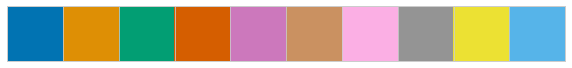

In [22]:
sns.palplot(sns.color_palette("colorblind", 10))

[Text(0, 0, 'resnet50'), Text(0, 0, 'stylenet50')]

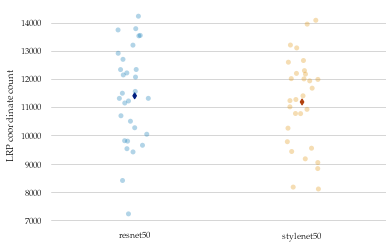

In [23]:
ax = sns.stripplot(data=comb[["res_len", "stl_len"]],
                  dodge=True, alpha=.3)

# Show the conditional means
ax = sns.pointplot(data=comb[["res_len", "stl_len"]],
              dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

ax.set(ylabel=' LRP coordinate count')
sns.despine(bottom = True, left = True)
ax.set_xticklabels(["resnet50", "stylenet50"])

In [24]:
ax.figure.savefig(folder / "lrp_count.pdf")

[Text(0, 0, 'resnet50 pos.'),
 Text(0, 0, 'resnet50 neg.'),
 Text(0, 0, 'stylenet50 pos.'),
 Text(0, 0, 'stylenet50 neg.')]

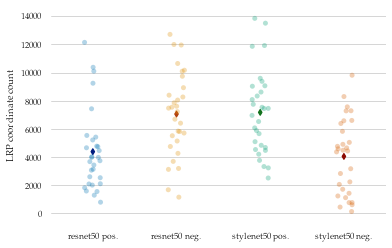

In [25]:
ax = sns.stripplot(data=comb[["res_pos_len", "res_neg_len", "stl_pos_len", "stl_neg_len"]],
                  dodge=True, alpha=.3)

# Show the conditional means
ax = sns.pointplot(data=comb[["res_pos_len", "res_neg_len", "stl_pos_len", "stl_neg_len"]],
              dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

ax.set(ylabel='LRP coordinate count')
sns.despine(bottom = True, left = True)
ax.set_xticklabels(["resnet50 pos.", "resnet50 neg.", "stylenet50 pos.", "stylenet50 neg."])

In [26]:
ax.figure.savefig(folder / "lrp_count_posneg.pdf")

#### Compare positive and negative lrp canny intersection

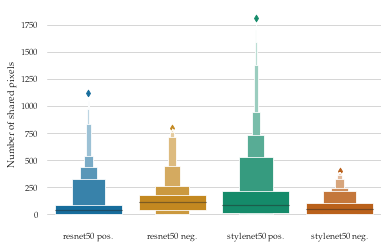

In [27]:
ax = sns.boxenplot(data=comb[["inter_res_pos", "inter_res_neg", "inter_stl_pos", "inter_stl_neg"]])

ax.set_xticklabels(["resnet50 pos.", "resnet50 neg.", "stylenet50 pos.", "stylenet50 neg."])
ax.set(ylabel='Number of shared pixels')
sns.despine(bottom = True, left = True)

- Noch einmal gewichtet wiederholen
- Wie viel lrp in der Bounding box?

In [28]:
ax.figure.savefig(folder / "lrp_canny.pdf")

#### Compare weighted positive and negative lrp canny intersection

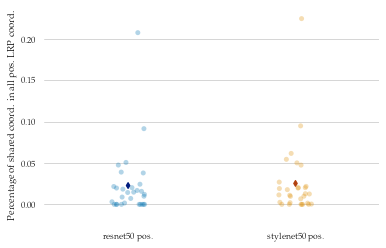

In [144]:
#ax = sns.boxenplot(data=comb[["inter_res_pos_perc", "inter_res_neg_perc", "inter_stl_pos_perc", "inter_stl_neg_perc"]])
ax = sns.stripplot(data=comb[["inter_res_pos_perc", "inter_stl_pos_perc"]],
                  dodge=True, alpha=.3)

# Show the conditional means
ax = sns.pointplot(data=comb[["inter_res_pos_perc", "inter_stl_pos_perc", ]],
              dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

ax.set_xticklabels(["resnet50 pos.", "stylenet50 pos.",])
ax.set(ylabel='Percentage of shared coord. in all pos. LRP coord.')
sns.despine(bottom = True, left = True)

In [145]:
ax.figure.savefig(folder / "lrp_canny_weighted.pdf")

In [31]:
comp_pos = (comb["inter_res_pos"] / comb["res_pos_len"]) < (comb["inter_stl_pos"] / comb["stl_pos_len"])
comp_pos.value_counts()

True     19
False    11
dtype: int64

In [32]:
comp_neg = (comb["inter_res_neg"] / comb["res_neg_len"]) > (comb["inter_stl_neg"] / comb["stl_neg_len"])
comp_neg.value_counts()

True     16
False    14
dtype: int64

In [33]:
res_perc_neg_pos = comb["inter_res_neg"] / comb["inter_res_pos"] > 1
res_perc_neg_pos.value_counts()

True     20
False    10
dtype: int64

In [34]:
stl_perc_neg_pos = comb["inter_stl_neg"] / comb["inter_stl_pos"] > 1
stl_perc_neg_pos.value_counts()

False    20
True     10
dtype: int64

#### Plot kernel densities

To get a sense of what regions appear often in both the LRP values of both networks and the Canny edge detection, kernel density plots may help. 

Canny coordinates (in `ImageNet` bounding box!)

In [98]:
x_canny = [elem[0] for lst in comb['edges'] for elem in lst]
y_canny = [elem[1] for lst in comb['edges'] for elem in lst]

(0, 224)

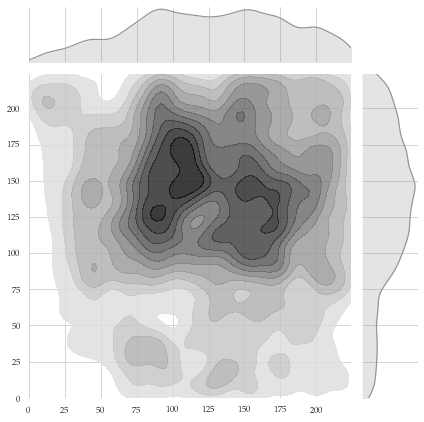

In [99]:
g = sns.jointplot(x=x_canny, y=y_canny, 
              kind="kde", color=sns.color_palette("colorblind")[7], alpha=0.8)
g.ax_joint.collections[0].set_alpha(0)
sns.despine(bottom = True, left = True)

# set axis limits to actual image size
g.ax_marg_x.set_xlim(0, 224)
g.ax_marg_y.set_ylim(0, 224)

In [100]:
g.savefig(folder / "canny_reg.pdf")

Positive LRP ResNet coordinates

In [101]:
x_lrp_res = [elem[0] for lst in res_pos.values() for elem in lst]
y_lrp_res = [elem[1] for lst in res_pos.values() for elem in lst]

(0, 224)

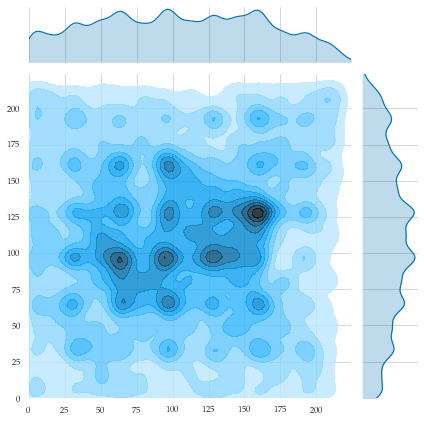

In [102]:
g = sns.jointplot(x=x_lrp_res, y=y_lrp_res,
              kind="kde", color=sns.color_palette("colorblind")[0], alpha=0.8)
g.ax_joint.collections[0].set_alpha(0)
sns.despine(bottom = True, left = True)

# set axis limits to actual image size
g.ax_marg_x.set_xlim(0, 224)
g.ax_marg_y.set_ylim(0, 224)

In [103]:
g.savefig(folder / "res_lrpos_reg.pdf")

Positive LRP StyleNet coordinates

In [104]:
x_lrp_stl = [elem[0] for lst in stl_pos.values() for elem in lst]
y_lrp_stl = [elem[1] for lst in stl_pos.values() for elem in lst]

(0, 224)

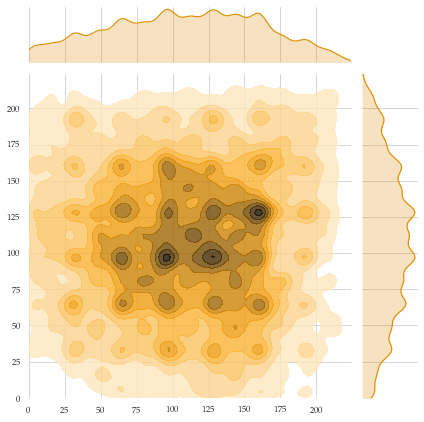

In [105]:
g = sns.jointplot(x=x_lrp_stl, y=y_lrp_stl, 
              kind="kde", color=sns.color_palette("colorblind")[1], alpha=0.8)
g.ax_joint.collections[0].set_alpha(0)
sns.despine(bottom = True, left = True)

# set axis limits to actual image size
g.ax_marg_x.set_xlim(0, 224)
g.ax_marg_y.set_ylim(0, 224)

In [106]:
g.savefig(folder / "stl_lrppos_reg.pdf")

Intersection LRP Canny ResNet

In [107]:
x_inter_res = [elem[0] for lst in inter_res_pos_coord for elem in lst]
y_inter_res = [elem[1] for lst in inter_res_pos_coord for elem in lst]

(0, 224)

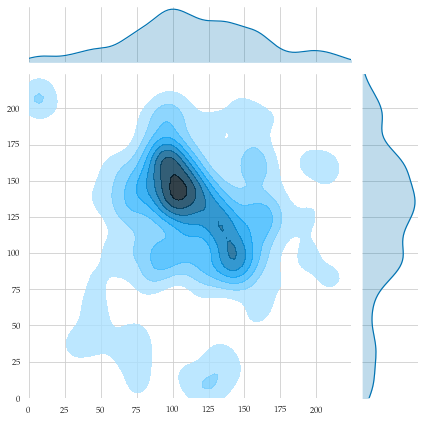

In [108]:
g = sns.jointplot(x=x_inter_res, y=y_inter_res, 
              kind="kde", color=sns.color_palette("colorblind")[0], alpha=0.8)
g.ax_joint.collections[0].set_alpha(0)
sns.despine(bottom = True, left = True)

# set axis limits to actual image size
g.ax_marg_x.set_xlim(0, 224)
g.ax_marg_y.set_ylim(0, 224)

In [109]:
g.savefig(folder / "res_inters.pdf")

Intersection LRP Canny StyleNet

In [110]:
x_inter_stl = [elem[0] for lst in inter_stl_pos_coord for elem in lst]
y_inter_stl = [elem[1] for lst in inter_stl_pos_coord for elem in lst]

(0, 224)

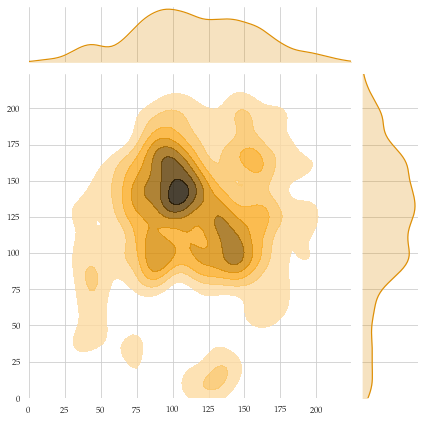

In [111]:
g = sns.jointplot(x=x_inter_stl, y=y_inter_stl, 
              kind="kde", color=sns.color_palette("colorblind")[1], alpha=0.8)
g.ax_joint.collections[0].set_alpha(0)
sns.despine(bottom = True, left = True)

# set axis limits to actual image size
g.ax_marg_x.set_xlim(0, 224)
g.ax_marg_y.set_ylim(0, 224)

In [112]:
g.savefig(folder / "stl_inters.pdf")

____________

## Some statistical tests

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy import stats

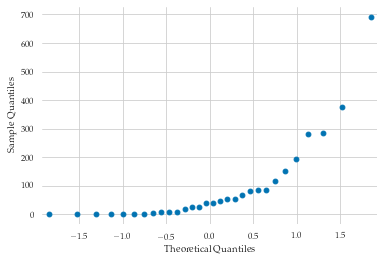

In [128]:
g = sm.qqplot(comb["inter_stl_pos"] - comb["inter_res_pos"], 
             color=sns.color_palette("colorblind")[0])
sns.despine(bottom = True, left = True)

g.savefig(folder / "qq_4.pdf")

In [120]:
stats.shapiro(comb["inter_res_pos"])

(0.5557712316513062, 2.1946389594518223e-08)

In [121]:
stats.shapiro(comb["inter_stl_pos"])

(0.5874334573745728, 5.144735482076612e-08)

The Shapiro test for the differences is important!

In [125]:
stats.shapiro(comb["inter_stl_pos"] - comb["inter_res_pos"])

(0.6441235542297363, 2.6392936547381396e-07)

#### Check if the positive lrp values of each network are equal (mean, distribution)

In [94]:
stats.pearsonr(comb["inter_res_pos"], comb["inter_stl_pos"])

(0.9954106755475988, 4.37807296993466e-30)

In [107]:
stats.wilcoxon(comb["inter_res_pos_perc"], comb["inter_stl_pos_perc"], alternative="less")

WilcoxonResult(statistic=61.0, pvalue=0.0054975086077635)

#### Check if the negative lrp values of each network are equal (mean, distribution)

In [261]:
stats.pearsonr(comb["inter_res_neg"], comb["inter_stl_neg"])

(0.8881530775359449, 5.854032788009722e-11)

In [106]:
stats.wilcoxon(comb["inter_res_neg_perc"], comb["inter_stl_neg_perc"], alternative="greater")

WilcoxonResult(statistic=217.0, pvalue=0.14593778305586774)